# Image Similarity Search

We used metric learning as the main algorithm, using the publicly available library `TensorFlow Similarity`.

The goal of metric learning is to train models that can embed inputs into a high-dimensional space, in order to push "dissimilar" inputs further apart and "similar" inputs closer to one another.

Within the embedding model, we also utilized  a standard convolutional network with a `MetricEmbedding` layer that incorporates L2 normalization. The ``MultiSimilarityLoss()`` loss function from ``TensorFlow Similarity`` is used. This loss tries to utilise all informative pairs in the batch, with consideration for self-similarity, positive similarity, and negative similarity.

For evaluating search performance, we computed several metrics such as precision, recall, accuracy, and F1 score. In addition, we also plotted the evolution of the metrics as the threshold distance changes, the precision-recall curve, as well as a confusion matrix.

References:
- Team, K. (n.d.). Keras documentation: Metric learning for image similarity search using TensorFlow Similarity. Metric Learning for Image Similarity Search Using TensorFlow Similarity. https://keras.io/examples/vision/metric_learning_tf_similarity/
- Team, K. (n.d.). Keras documentation: Metric learning for image similarity search. Metric Learning for Image Similarity Search. https://keras.io/examples/vision/metric_learning/
- Practical Deep Learning for Cloud, Mobile, and Edge. (n.d.). O’Reilly Online Learning. https://www.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html
- Team, K. (n.d.). Keras documentation: Near-duplicate image search. Near-duplicate Image Search. https://keras.io/examples/vision/near_dup_search/
- Agrawal, A. (2019, March 30). Finding similar images using Deep learning and Locality Sensitive Hashing. Medium. https://towardsdatascience.com/finding-similar-images-using-deep-learning-and-locality-sensitive-hashing-9528afee02f5
- Wang, Xun, et al. "Multi-similarity loss with general pair weighting for deep metric learning." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2019.

First, we import the relevant Python libraries.

In [1]:
!pip install -q tensorflow_similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import random

from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow_similarity as tfsim


tfsim.utils.tf_cap_memory()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity:", tfsim.__version__)

TensorFlow: 2.11.0
TensorFlow Similarity: 0.16.10


In [3]:
IMG_SIZE = 64  # @param {type:"integer"}

# preprocessing function that resizes images to ensure all images are the same shape
def resize(img, label):
      with tf.device("/cpu:0"):
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
      return img, label

For this example, the `tf_flowers` dataset will be used. There are 5 classes in the dataset, namely "dandelion", "daisy", "tulips", "sunflowers", and "roses".

Each batch needs to have at least two samples of each class for the similarity model to learn well.

The `tf_similarity` library provides `Sampler` objects that let us select the minimum number of examples of each class per batch, as well as the number of classes per batch.

The `TFDatasetMultiShotMemorySampler` object will be used to construct the train and validation datasets. This produces batches with a target number of classes and a target number of examples per class, and constructs a sampler that loads datasets from TensorFlow Datasets.

In [4]:
# This determines the number of classes used during training.
# Here we are using all the classes.
num_known_classes = 5
class_list = random.sample(population=range(5), k=num_known_classes)

classes_per_batch = 5
# Passing multiple examples per class per batch ensures that each example has
# multiple positive pairs. In general, more examples per
# class will lead to more information for the positive pairs, while more classes
# per batch will provide more varied information in the negative pairs. 
examples_per_class_per_batch = 8

print(
    "Batch size is: "
    f"{min(classes_per_batch, num_known_classes) * examples_per_class_per_batch}"
)

print(" Create Training Data ".center(34, "#"))
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "tf_flowers",
    classes_per_batch=min(classes_per_batch, num_known_classes),
    splits="train[:80%]",
    steps_per_epoch=4000,
    examples_per_class_per_batch=examples_per_class_per_batch,
    class_list=class_list,
    preprocess_fn=resize,
)

print("\n" + " Create Validation Data ".center(34, "#"))
val_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "tf_flowers",
    classes_per_batch=classes_per_batch,
    splits="train[80%:]",
    total_examples_per_class=100,
    preprocess_fn=resize,
)

Batch size is: 40
###### Create Training Data ######


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


converting train[:80%]:   0%|          | 0/2936 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/2936 [00:00<?, ?it/s]


The initial batch size is 40 (5 classes * 8 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/2936 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/5 [00:00<?, ?it/s]

gather examples:   0%|          | 0/2936 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/2936 [00:00<?, ?it/s]


##### Create Validation Data #####


converting train[80%:]:   0%|          | 0/734 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/734 [00:00<?, ?it/s]


The initial batch size is 10 (5 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/734 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/5 [00:00<?, ?it/s]

gather examples:   0%|          | 0/500 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/500 [00:00<?, ?it/s]

We visualize a few examples from the dataset. Note that the samplers would shuffle the dataset.

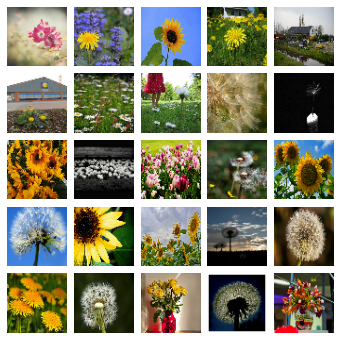

In [5]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)

fig = plt.figure(figsize=(6.0, 6.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for ax, im, label in zip(grid, x_slice, y_slice):
    ax.imshow(im.astype('uint8'))
    ax.axis("off")

With the help of the Keras library, we define a `SimilarityModel` next. The model is a conventional convolutional network with a `MetricEmbedding` layer that incorporates L2 normalization. When employing the cosine distance, the metric embedding layer is helpful because we are only interested in the angle between the vectors.

In [6]:
def build_model():
  embedding_size = 256

  inputs = keras.layers.Input((64, 64, 3))
  x = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
  x = keras.layers.Conv2D(64, 3, activation="relu")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(128, 3, activation="relu")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D((4, 4))(x)
  x = keras.layers.Conv2D(256, 3, activation="relu")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(256, 3, activation="relu")(x)
  x = keras.layers.GlobalMaxPool2D()(x)
  outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)

  # building model
  model = tfsim.models.SimilarityModel(inputs, outputs)
  model.summary()
  return model

When computing the loss over the pairwise positive and negative distances, the similarity loss expects batches with at least two examples of each class. One of the losses in TensorFlow Similarity, `MultiSimilarityLoss()`, is used in this instance. With consideration for self-similarity, positive similarity, and negative similarity, this loss attempts to utilise all informative pairs in the batch.

In [7]:
def train_model(model):
  epochs = 3
  learning_rate = 0.002
  val_steps = 50

  # init similarity loss
  loss = tfsim.losses.MultiSimilarityLoss()

  # compiling and training
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate), loss=loss, steps_per_execution=10,
  )
  history = model.fit(
      train_ds, epochs=epochs, validation_data=val_ds, validation_steps=val_steps
  )
  return model

After our model has been trained, we can build an index of examples. By providing the x and y to the index along with the image being stored in the data parameter, we batch index the first 200 validation examples. To make the x index values searchable, they are embedded and then added to the index.

In [8]:
def build_index(model):
  x_index, y_index = val_ds.get_slice(begin=0, size=200)
  model.reset_index()
  model.index(x_index, y_index, data=x_index)
  return model

Using a matching method and a calibration metric, we can calibrate a distance threshold after the index has been created.

Here, we are using K=1 as our classifier and looking for the best F1 score. The query example and the label attached to the match result will be labeled as a Positive match for all matches at or below the calibrated threshold distance, and a Negative match for all matches over the threshold distance.

In [9]:
def calibrate(model):
  x_train, y_train = train_ds.get_slice(begin=0, size=1000)
  calibration = model.calibrate(
      x_train,
      y_train,
      calibration_metric="f1",
      matcher="match_nearest",
      extra_metrics=["precision", "recall", "binary_accuracy"],
      verbose=1,
  )
  return model,calibration

In [10]:
# Index is included in the model
def construct_index():
  model = build_model()
  model = train_model(model)
  model = build_index(model)
  model,calibration = calibrate(model)
  return model, calibration

In [11]:
index, calibration = construct_index()
# calibration results are used later as they include metrics to measure the matching performance

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 128)      512       
 hNormalization)                                  

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[Indexing 200 points]
|-Computing embeddings
7/7 [==============================] - 1s 87ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.
32/32 [==============================] - 0s 8ms/step

Performing NN search



Building NN list:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]


 name        value    distance    precision    recall    binary_accuracy        f1
-------  --------  ----------  -----------  --------  -----------------  --------
optimal  0.995984    0.190915        0.992         1              0.992  0.995984


The retrieval function takes a query image (to be precise, a number corresponding to a query image in the validation dataset), and the index as arguments, and returns and visualizes the K most "similar" images, including the distances to the query example.

In [12]:
def retrieval_function(query_image_num, index):
  K = 5 # returns K most “similar” images
  labels = [
      "dandelion",
      "daisy",
      "tulips",
      "sunflowers",
      "roses",
  ]
  class_mapping = {c_id: c_lbl for c_id, c_lbl in zip(range(11), labels)}

  x_display, y_display = val_ds.get_slice(begin=200+query_image_num, size=1)
  # lookup nearest neighbors in the index
  nns = index.lookup(x_display, k=K)

  # display
  idx = 0
  for i in range(0,K):
    nns[idx][i].data = nns[idx][i].data.astype('uint8')
    #print(nns[idx][i])
  tfsim.visualization.viz_neigbors_imgs(
      x_display[idx].astype('uint8'),
      y_display[idx].astype('uint8'),
      nns[idx],
      class_mapping=class_mapping,
      fig_size=(16, 2),
  )
  return nns

1/1 [==============================] - 0s 94ms/step

Performing NN search



Building NN list:   0%|          | 0/1 [00:00<?, ?it/s]

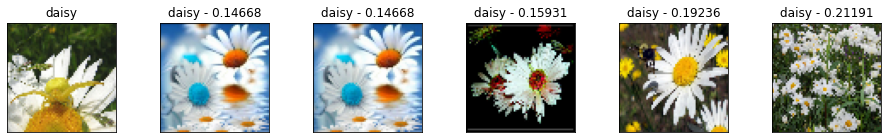

In [13]:
# K nearest images to query image 0 (query_image_num=0)
nns = retrieval_function(0, index)

1/1 [==============================] - 0s 22ms/step

Performing NN search



Building NN list:   0%|          | 0/1 [00:00<?, ?it/s]

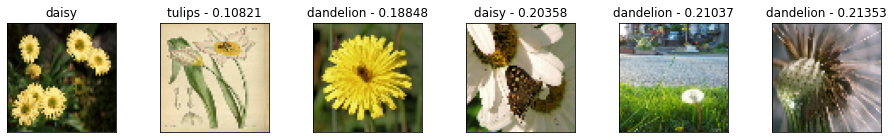

In [14]:
nns = retrieval_function(1, index)

1/1 [==============================] - 0s 24ms/step

Performing NN search



Building NN list:   0%|          | 0/1 [00:00<?, ?it/s]

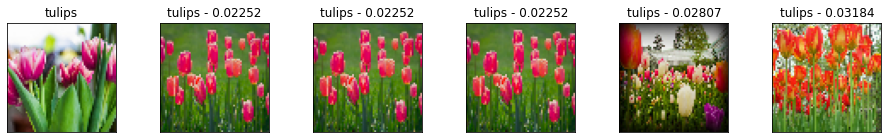

In [15]:
nns = retrieval_function(2, index)

1/1 [==============================] - 0s 20ms/step

Performing NN search



Building NN list:   0%|          | 0/1 [00:00<?, ?it/s]

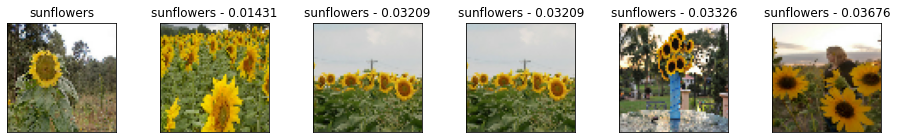

In [16]:
nns = retrieval_function(3, index)

1/1 [==============================] - 0s 22ms/step

Performing NN search



Building NN list:   0%|          | 0/1 [00:00<?, ?it/s]

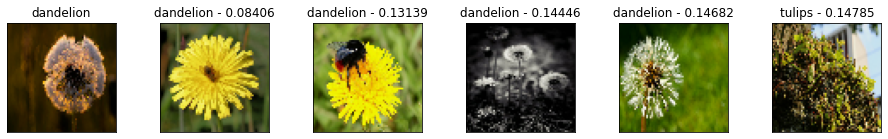

In [17]:
nns = retrieval_function(4, index)

During the calibration (`calibrate(model) `) in Step 3, we have computed some metrics while using K=1 as our classifier and looking for the best F1 score.

Other metrics are also computed, using the calibrated threshold. We record the values here (the output was generated when running `construct_index()`:



In [18]:
precision = round(calibration.cutpoints['optimal']['precision'],3)
print('precision: ',precision)

recall = round(calibration.cutpoints['optimal']['recall'],3)
print('recall: ', recall)

binary_accuracy = round(calibration.cutpoints['optimal']['binary_accuracy'],3)
print('binary_accuracy: ', binary_accuracy)

f1 = round(calibration.cutpoints['optimal']['f1'],3)
print('f1: ', f1)

precision:  0.992
recall:  1.0
binary_accuracy:  0.992
f1:  0.996


Though the model is not perfect, the high metrics (above 0.9) demonstrates that the model is able to locate similar images regardless of the spatial pose or illumination of the photographs.

To visualize the matching performance as the distance threshold rises, we can also plot the other metrics found in the `CalibrationResults`.

The Precision, Recall, and F1 Score are displayed in the following charts.

We can see that the matching precision declines slightly as the distance increases, while the fraction of queries that we accept as positive matches (recall) grow more quickly up to the calibrated distance threshold.

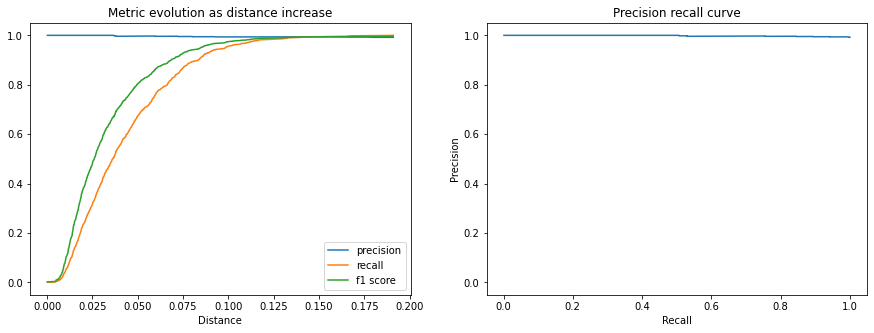

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
x = calibration.thresholds["distance"]

ax1.plot(x, calibration.thresholds["precision"], label="precision")
ax1.plot(x, calibration.thresholds["recall"], label="recall")
ax1.plot(x, calibration.thresholds["f1"], label="f1 score")
ax1.legend()
ax1.set_title("Metric evolution as distance increase")
ax1.set_xlabel("Distance")
ax1.set_ylim((-0.05, 1.05))

ax2.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax2.set_title("Precision recall curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_ylim((-0.05, 1.05))
plt.show()

The confusion matrix for each case and its closest match can also be plotted using 100 examples from each class.

In order to indicate matches that are above the calibrated distance threshold, we also include an additional class label "5".

We see that most of the errors occur in the "roses" and "tulips" classes. Furthermore, we observe that only a small fraction of the 100 samples for each class returned matches outside of the calibrated distance threshold.

16/16 [==============================] - 0s 23ms/step


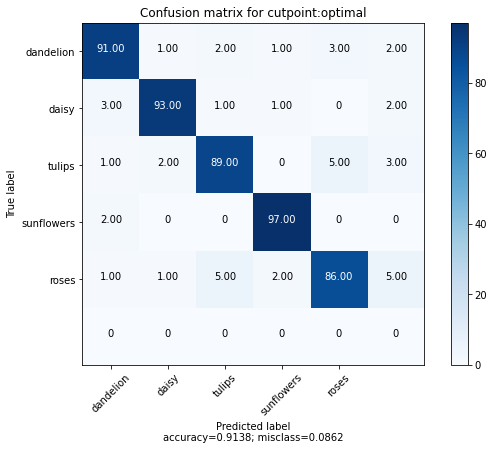

In [20]:
cutpoint = "optimal"

labels = [
      "dandelion",
      "daisy",
      "tulips",
      "sunflowers",
      "roses",
  ]

# This yields 100 examples for each class.
# We defined this when we created the val_ds sampler.
x_confusion, y_confusion = val_ds.get_slice(0, -1)

matches = index.match(x_confusion, cutpoint=cutpoint, no_match_label=5)
cm = tfsim.visualization.confusion_matrix(
    matches,
    y_confusion,
    labels=labels,
    title="Confusion matrix for cutpoint:%s" % cutpoint,
    normalize=False,
)